# Classification attempt using ch7_classification

In [243]:
import sys
# !conda install --yes --prefix {sys.prefix} scikit-learn
# !conda install --yes --prefix {sys.prefix} xgboost
# !conda install --yes --prefix {sys.prefix} seaborn
# !conda install --yes --prefix {sys.prefix} matplotlib

%matplotlib inline

In [244]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from util import util
from util.VisualizeDataset import VisualizeDataset

In [245]:
dataset = pd.read_csv("./A3_dataset/COMBINED_ch4_result.csv")
print(dataset.columns)
dataset.head()

Index(['Unnamed: 0', 'acc_x', 'acc_y', 'acc_z', 'grav_x', 'grav_y', 'grav_z',
       'lin_x', 'lin_y', 'lin_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'time_since_start', 'timestamp_date', 'timestamp_ms', 'label-jogging',
       'label-cycling', 'label-football', 'label-jumprope', 'label-pushups',
       'label-sitting', 'label-swimming', 'label-tennis', 'label-walking',
       'lin_x_max_freq_ws20', 'lin_y_max_freq_ws20', 'lin_z_max_freq_ws20',
       'lin_x_max_freq_ws40', 'lin_y_max_freq_ws40', 'lin_z_max_freq_ws40'],
      dtype='object')


,Unnamed: 0,acc_x,acc_y,acc_z,grav_x,grav_y,grav_z,lin_x,lin_y,lin_z,...,label-sitting,label-swimming,label-tennis,label-walking,lin_x_max_freq_ws20,lin_y_max_freq_ws20,lin_z_max_freq_ws20,lin_x_max_freq_ws40,lin_y_max_freq_ws40,lin_z_max_freq_ws40
0,0,5.00870,3.5865,6.0478,3.00250,4.03080,8.42070,2.0062,-0.4442,-2.3730,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9.29790,-9.0417,3.4058,6.11765,3.60885,3.77155,1.2018,2.6037,9.4019,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,13.58710,-21.6699,0.7638,9.23280,3.18690,-0.87760,22.8759,-0.5101,20.9578,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5.62875,0.4956,10.9619,8.47780,-1.96420,-4.52110,4.7023,23.7443,25.2070,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,-2.32960,22.6611,21.1600,8.37730,-2.77790,-4.27480,1.3718,25.8676,28.1546,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Knn classification

In [246]:
from sklearn.neighbors import KNeighborsClassifier

# Making a single label column
labels = ['label-jogging','label-cycling', 'label-football', 'label-jumprope', 'label-pushups', 'label-sitting', 'label-swimming', 'label-tennis', 'label-walking']
activities = ['jogging','cycling', 'football', 'jumprope', 'pushups', 'sitting', 'swimming', 'tennis', 'walking']

activity_labels = []

for i in range(len(dataset)):
    for j in range(len(labels)):
        if dataset[labels[j]][i] == 1:
            activity_labels.append(activities[j])


In [247]:
from collections import Counter
Counter(activity_labels)

Counter({'jogging': 303,
         'cycling': 6764,
         'football': 9549,
         'jumprope': 2902,
         'pushups': 418,
         'sitting': 17195,
         'swimming': 3034,
         'tennis': 14360,
         'walking': 1435})

In [248]:
# Quickly impute every instance of missing values with median

dataset_filled = dataset.copy()
dataset_columns = dataset_filled.columns
dataset_filled[dataset_columns] = dataset_filled[dataset_columns].fillna(dataset_filled[dataset_columns].mean())

/tmp/ipykernel_20722/3761499697.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_filled[dataset_columns] = dataset_filled[dataset_columns].fillna(dataset_filled[dataset_columns].mean())


In [249]:
dataset_filled = dataset_filled.drop(labels + ["Unnamed: 0", "timestamp_date", "timestamp_ms", "time_since_start", 

       # 'lin_x_max_freq_ws20', 'lin_y_max_freq_ws20', 'lin_z_max_freq_ws20', 'lin_x_max_freq_ws40',
       # 'lin_y_max_freq_ws40', 'lin_z_max_freq_ws40'
       
       ], axis=1)

In [250]:
dataset_filled.columns

Index(['acc_x', 'acc_y', 'acc_z', 'grav_x', 'grav_y', 'grav_z', 'lin_x',
       'lin_y', 'lin_z', 'gyr_x', 'gyr_y', 'gyr_z', 'lin_x_max_freq_ws20',
       'lin_y_max_freq_ws20', 'lin_z_max_freq_ws20', 'lin_x_max_freq_ws40',
       'lin_y_max_freq_ws40', 'lin_z_max_freq_ws40'],
      dtype='object')

In [251]:
X_train, X_test, y_train, y_test = train_test_split(dataset_filled, activity_labels, test_size=0.33, shuffle=True)

In [252]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
ypreds=knn_clf.predict(X_test)

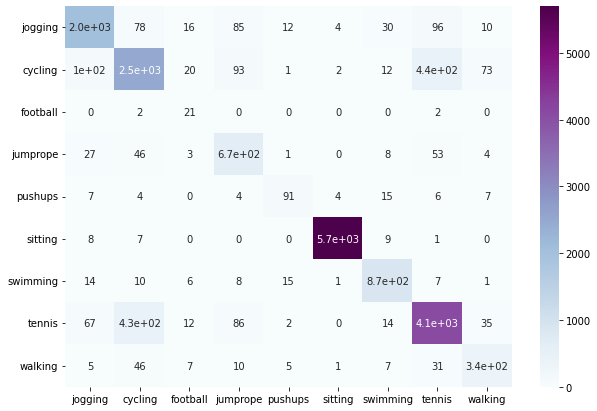

In [253]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(list(ypreds), y_test)
df_cm = pd.DataFrame(conf_matrix, index = activities, columns = activities)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")
plt.savefig("./daim_figures/knn_classification.png")
plt.show()

In [254]:
conf_matrix

array([[2050,   78,   16,   85,   12,    4,   30,   96,   10],
       [ 100, 2504,   20,   93,    1,    2,   12,  445,   73],
       [   0,    2,   21,    0,    0,    0,    0,    2,    0],
       [  27,   46,    3,  667,    1,    0,    8,   53,    4],
       [   7,    4,    0,    4,   91,    4,   15,    6,    7],
       [   8,    7,    0,    0,    0, 5698,    9,    1,    0],
       [  14,   10,    6,    8,   15,    1,  874,    7,    1],
       [  67,  427,   12,   86,    2,    0,   14, 4114,   35],
       [   5,   46,    7,   10,    5,    1,    7,   31,  336]])

In [255]:
from sklearn.metrics import f1_score

f1_score(y_test, ypreds, average='weighted')

0.8846473030886566

### Quick test

In [256]:
ypreds_test = []

for i in range(len(y_test)):
    ypreds_test.append("sitting")

f1_score(y_test, ypreds_test, average='weighted')

0.146050635986326

# Random Forest

In [257]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier()
clf.fit(X_train,y_train)
ypreds=clf.predict(X_test)

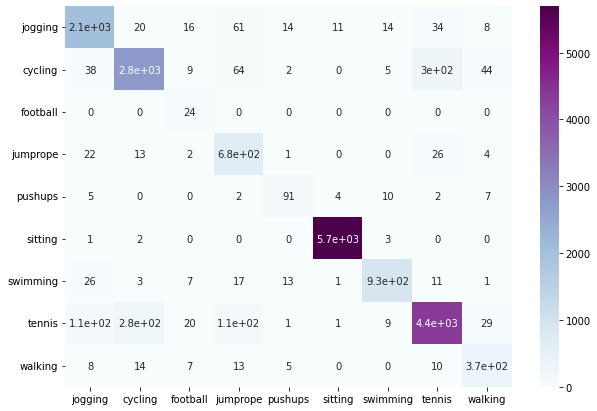

In [258]:
conf_matrix = confusion_matrix(list(ypreds), y_test)
df_cm = pd.DataFrame(conf_matrix, index = activities, columns = activities)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")
plt.savefig("./daim_figures/r_forest_classification.png")
plt.show()

In [259]:
conf_matrix

array([[2065,   20,   16,   61,   14,   11,   14,   34,    8],
       [  38, 2793,    9,   64,    2,    0,    5,  303,   44],
       [   0,    0,   24,    0,    0,    0,    0,    0,    0],
       [  22,   13,    2,  685,    1,    0,    0,   26,    4],
       [   5,    0,    0,    2,   91,    4,   10,    2,    7],
       [   1,    2,    0,    0,    0, 5693,    3,    0,    0],
       [  26,    3,    7,   17,   13,    1,  928,   11,    1],
       [ 113,  279,   20,  111,    1,    1,    9, 4369,   29],
       [   8,   14,    7,   13,    5,    0,    0,   10,  373]])

# Boosting

In [260]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train,y_train)
ypreds=clf.predict(X_test)

/home/damion/anaconda3/envs/mlqs/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/damion/anaconda3/envs/mlqs/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:20:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


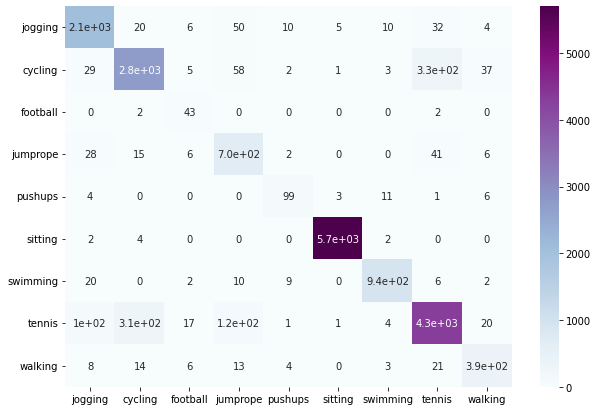

In [261]:
conf_matrix = confusion_matrix(list(ypreds), y_test)
df_cm = pd.DataFrame(conf_matrix, index = activities, columns = activities)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")
plt.savefig("./daim_figures/xgboost_classification.png")
plt.show()

In [262]:
conf_matrix

array([[2083,   20,    6,   50,   10,    5,   10,   32,    4],
       [  29, 2758,    5,   58,    2,    1,    3,  332,   37],
       [   0,    2,   43,    0,    0,    0,    0,    2,    0],
       [  28,   15,    6,  705,    2,    0,    0,   41,    6],
       [   4,    0,    0,    0,   99,    3,   11,    1,    6],
       [   2,    4,    0,    0,    0, 5700,    2,    0,    0],
       [  20,    0,    2,   10,    9,    0,  936,    6,    2],
       [ 104,  311,   17,  117,    1,    1,    4, 4320,   20],
       [   8,   14,    6,   13,    4,    0,    3,   21,  391]])